# 02. Neural Network Classification with TensorFlow

Okay, we've seen how to deal with a regression problem in TensorFlow, let's look at how we can approach a classification problem.

A [classification problem](https://en.wikipedia.org/wiki/Statistical_classification) involves predicting whether something is one thing or another.

For example, you might want to:

- Predict whether or not someone has heart disease based on their health parameters. This is called binary classification since there are only two options.
- Could you decide whether a photo is of food, a person, or a dog? This is called multi-class classification since there are more than two options.
- Predict what categories should be assigned to a Wikipedia article. This is called multi-label classification since a single article could have more than one category assigned.

In this notebook, we're going to work through several different classification problems with TensorFlow. In other words, taking a set of inputs and predicting what class those inputs belong to.

## What we're going to cover

Specifically, we're going to go through doing the following with TensorFlow:

- Architecture of a classification model
- Input shapes and output shapes
    - `X`: features/data (inputs)
    - `y`: labels (outputs)
        - "What class do the inputs belong to?"
- Creating custom data to view and fit
- Steps in modeling for binary and multiclass classification
    - Creating a model
    - Compiling a model
        - Defining a loss function
        - Setting up an optimizer
            - Finding the best learning rate
        - Creating evaluation metrics
    - Fitting a model (getting it to find patterns in our data)
    - Improving a model
- The power of non-linearity
- Evaluating classification models
    - Visualizing the model ("visualize, visualize, visualize")
    - Looking at training curves
    - Compare predictions to ground truth (using our evaluation metrics)

## How you can use this notebook

You can read through the descriptions and the code (it should all run, except for the cells that error on purpose), but there's a better option.

Write all of the code yourself.

Yes. I'm serious. Create a new notebook, and rewrite each line by yourself. Investigate it, see if you can break it, and why it breaks.

You don't have to write the text descriptions but writing the code yourself is a great way to get hands-on experience.

Don't worry if you make mistakes, we all do. The way to get better and make less mistakes is to write more code.

## Typical architecture of a classification neural network

The word *typical* is on purpose.

Because the architecture of a classification neural network can widely vary depending on the problem you're working on.

However, there are some fundamentals all deep neural networks contain:

- An input layer.
- Some hidden layers.
- An output layer.

Much of the rest is up to the data analyst creating the model.

The following are some standard values you'll often use in your classification neural networks.

| **Hyperparameter**| **Binary Classification** |	**Multiclass classification** |
|--|--|--|
| Input layer shape| Same as number of features (e.g. 5 for age, sex, height,<br>weight, smoking status in heart disease prediction)|	Same as binary classification|
|Hidden layer(s)|	Problem specific, minimum = 1, maximum = unlimited	|Same as binary classification|
|Neurons per hidden layer|	Problem specific, generally 10 to 100|	Same as binary classification|
|Output layer shape|	1 (one class or the other)	|1 per class (e.g. 3 for food, person or dog photo)|
|Hidden activation|	Usually [ReLU](https://www.kaggle.com/dansbecker/rectified-linear-units-relu-in-deep-learning) (rectified linear unit)|	Same as binary classification|
|Output activation|	[Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function)|	[Softmax](https://en.wikipedia.org/wiki/Softmax_function)|
|Loss function|	[Cross entropy](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression) ([`tf.keras.losses.BinaryCrossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)<br>in TensorFlow)|	Cross entropy ([`tf.keras.losses.CategoricalCrossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy)<br>in TensorFlow)|
|Optimizer|	[SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) (stochastic gradient descent), [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)	|Same as binary classification|

Table 1: Typical architecture of a classification network. Source: Adapted from page 295 of [Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow Book by Aurélien Géron](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)

Don't worry if not much of the above makes sense right now, we'll get plenty of experience as we go through this notebook.

Let's start by importing TensorFlow as the common alias tf. For this notebook, make sure you're using version 2.x+.

In [1]:
import tensorflow as tf
print(tf.__version__)

import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

2.14.0
Notebook last run (end-to-end): 2023-10-30 02:50:47.864730


## Creating data to view and fit

We could start by importing a classification dataset but let's practice making some of our classification data.

> 🔑 Note: It's a common practice to get you and the model you build working on a toy (or simple) dataset before moving to your actual problem. Treat it as a rehearsal experiment before the actual experiment(s).

Since classification is predicting whether something is one thing or another, let's make some data to reflect that.

To do so, we'll use Scikit-Learn's [`make_circles()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html#sklearn.datasets.make_circles) function.

In [2]:
from sklearn.datasets import make_circles

# Make 1000 examples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

Wonderful, now we've created some data, let's look at the features (`X`) and labels (`y`).

In [3]:
# Check out the features
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [4]:
# See the first 10 labels
y[:10]

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0])

Okay, we've seen some of our data and labels, how about we move towards visualizing?

> 🔑 Note: One important step in starting any kind of machine learning project is to [become one with the data](https://karpathy.github.io/2019/04/25/recipe/). One of the best ways to do this is to visualize the data you're working with as much as possible. The data explorer's motto is "visualize, visualize, visualize".

We'll start with a data frame.

In [5]:
# Make data frame of features and labels
import pandas as pd

circles = pd.DataFrame({"X0":X[:, 0], "X1":X[:, 1], "label":y})
circles

,X0,X1,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
...,...,...,...
995,0.244054,0.944125,0
996,-0.978655,-0.272373,0
997,-0.136900,-0.810012,1
998,0.670362,-0.767502,0


What kind of labels are we dealing with?

In [6]:
# Check out the different labels
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

Alright, looks like we're dealing with a binary classification problem. It's binary because there are only two labels (0 or 1).

If there were more label options (e.g. 0, 1, 2, 3, or 4), it would be called multiclass classification.

Let's take our visualization a step further and plot our data.

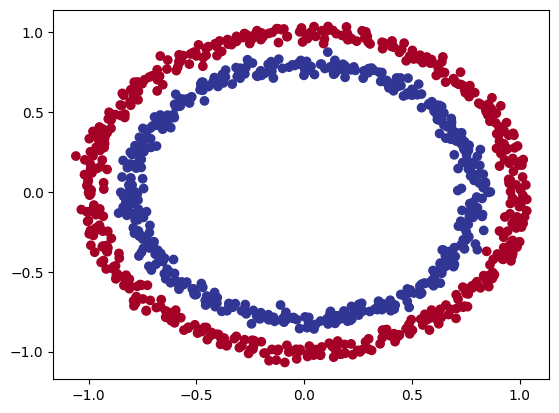

In [7]:
# Visualize with a plot
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

Nice! From the plot, can you guess what kind of model we might want to build?

How about we try and build one to classify blue or red dots? As in, a model which can distinguish blue from red dots.

> 🛠 Practice: Before pushing forward, you might want to spend 10 minutes playing around with the [TensorFlow Playground](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=2,2&seed=0.93799&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularization_hide=true&regularizationRate_hide=true&batchSize_hide=true). Try adjusting the different hyperparameters you see and click play to see a neural network train. I think you'll find the data very similar to what we've just created.

## Input and output shapes

One of the most common issues you'll run into when building neural networks is shape mismatches.

More specifically, the shape of the input data and the shape of the output data.

In our case, we want to input `X` and get our model to predict `y`.

So let's check out the shapes of `X` and `y`.

In [8]:
# Check the shapes of our features and labels
X.shape, y.shape

((1000, 2), (1000,))

Hmm, where do these numbers come from?

In [9]:
# Check how many samples we have
len(X), len(y)

(1000, 1000)

So we've got as many `X` values as we do `y` values, that makes sense.

Let's check out one example of each.

In [10]:
# View the first example of features and labels
X[0], y[0]

(array([0.75424625, 0.23148074]), 1)

Alright, so we've got two `X` features which lead to one `y` value.

This means our neural network input shape will have to accept a tensor with at least one dimension being two and output a tensor with at least one value.

> 🤔 Note: `y` having a shape of (1000,) can seem confusing. However, this is because all `y` values are actually scalars (single values) and therefore don't have a dimension. For now, think of your output shape as being at least the same value as one example of `y` (in our case, the output from our neural network has to be at least one value).

## Steps in modeling

Now we know what data we have as well as the input and output shapes, let's see how we'd build a neural network to model it.

In TensorFlow, there are typically 3 fundamental steps to creating and training a model.

1. Creating a model - piece together the layers of a neural network yourself (using the [functional](https://www.tensorflow.org/guide/keras/functional) or [sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)) or import a previously built model (known as transfer learning).
2. Compiling a model - defining how a model's performance should be measured (loss/metrics) as well as defining how it should improve (optimizer).
3. Fitting a model - letting the model try to find patterns in the data (how does `X` get to `y`).

Let's see these in action using the Sequential API to build a model for our regression data. And then we'll step through each.

In [11]:
# Set random seed
tf.random.set_seed(42)

# 1. Create the model using the Sequential API
model_1 = tf.keras.Sequential([
  tf.keras.layers.Dense(1)
])

# 2. Compile the model
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(), # binary since we are working with 2 clases (0 & 1)
                optimizer=tf.keras.optimizers.SGD(),
                metrics=['accuracy'])

# 3. Fit the model
model_1.fit(X, y, epochs=5)

Epoch 1/5
32/32 [==============================] - 2s 3ms/step - loss: 1.0196 - accuracy: 0.4700
Epoch 2/5
32/32 [==============================] - 0s 3ms/step - loss: 0.7011 - accuracy: 0.4740
Epoch 3/5
32/32 [==============================] - 0s 3ms/step - loss: 0.6965 - accuracy: 0.4660
Epoch 4/5
32/32 [==============================] - 0s 8ms/step - loss: 0.6946 - accuracy: 0.4770
Epoch 5/5
32/32 [==============================] - 0s 9ms/step - loss: 0.6942 - accuracy: 0.4790


Looking at the accuracy metric, our model performs poorly (50% accuracy on a binary classification problem is the equivalent of guessing), but what if we trained it for longer?

In [12]:
# Train our model for longer (more chances to look at the data)
model_1.fit(X, y, epochs = 200, verbose = 0) # set verbose = 0 to remove training updates
model_1.evaluate(X, y)

32/32 [==============================] - 0s 2ms/step - loss: 0.6935 - accuracy: 0.5000


[0.6934831142425537, 0.5]

Even after 200 passes of the data, it's still performing as if it's guessing.

What if we added an extra layer and trained for a little longer?

In [13]:
# Set random seed
tf.random.set_seed(42)

# 1. Create the model (same as model_1 but with an extra layer)
model_2 = tf.keras.Sequential([
  tf.keras.layers.Dense(1), # add an extra layer
  tf.keras.layers.Dense(1)
])

# 2. Compile the model
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.SGD(),
                metrics=['accuracy'])

# 3. Fit the model
model_2.fit(X, y, epochs = 100, verbose = 0) # set verbose = 0 to make the output print less

In [14]:
# Evaluate the model
model_2.evaluate(X, y)

32/32 [==============================] - 0s 1ms/step - loss: 7.6246 - accuracy: 0.5000


[7.6246185302734375, 0.5]

Still not even as good as guessing (~50% accuracy)... hmm...?

Let's remind ourselves of a couple more ways we can use to improve our models.

## Improving a model

To improve our model, we can alter almost every part of the 3 steps we went through before.

1. Creating a model - here you might want to add more layers, increase the number of hidden units (also called neurons) within each layer, change the activation functions of each layer.
2. Compiling a model - you might want to choose a different optimization function (such as the [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) optimizer, which is usually pretty good for many problems) or perhaps change the learning rate of the optimization function.
3. Fitting a model - perhaps you could fit a model for more epochs (leave it training for longer).

![image0](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-improving-a-model-from-model-perspective.png)
*There are many different ways to potentially improve a neural network. Some of the most common include: increasing the number of layers (making the network deeper), increasing the number of hidden units (making the network wider) and changing the learning rate. Because these values are all human-changeable, they're referred to as [hyperparameters](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning), and the practice of trying to find the best hyperparameters is referred to as [hyperparameter tuning](https://en.wikipedia.org/wiki/Hyperparameter_optimization).*

How about we try adding more neurons, an extra layer and our friend the Adam optimizer?

Surely doing this will result in predictions better than guessing...

> Note: The following message (below this one) can be ignored if you're running TensorFlow 2.8.0+, the error seems to have been fixed.

> Note: If you're using TensorFlow 2.7.0+ (but not 2.8.0+) the original code from the following cells may have caused some errors. They've since been updated to fix those errors. You can see explanations on what happened at the following resources:

- [Example Colab Notebook](https://colab.research.google.com/drive/1_dlrB_DJOBS9c9foYJs49I0YwN7LTakl?usp=sharing)
- [TensorFlow for Deep Learning GitHub Discussion on TensorFlow 2.7.0 breaking changes](https://github.com/mrdbourke/tensorflow-deep-learning/discussions/278)

In [15]:
# Set random seed
tf.random.set_seed(42)

# 1. Create the model (this time 3 layers)
model_3 = tf.keras.Sequential([
  # Before TensorFlow 2.7.0
  # tf.keras.layers.Dense(100), # add 100 dense neurons

  # With TensorFlow 2.7.0
  # tf.keras.layers.Dense(100, input_shape=(None, 1)), # add 100 dense neurons

  ## After TensorFlow 2.8.0 ##
  tf.keras.layers.Dense(100), # add 100 dense neurons
  tf.keras.layers.Dense(10), # add another layer with 10 neurons
  tf.keras.layers.Dense(1)
])

# 2. Compile the model
model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(), # use Adam instead of SGD
                metrics=['accuracy'])

# 3. Fit the model
model_3.fit(X, y, epochs = 100, verbose = 1) # fit for 100 passes of the data

Epoch 1/100
32/32 [==============================] - 2s 8ms/step - loss: 2.9152 - accuracy: 0.4530
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 0.7121 - accuracy: 0.4940
Epoch 3/100
32/32 [==============================] - 1s 17ms/step - loss: 0.6950 - accuracy: 0.5050
Epoch 4/100
32/32 [==============================] - 1s 20ms/step - loss: 0.6968 - accuracy: 0.4790
Epoch 5/100
32/32 [==============================] - 0s 8ms/step - loss: 0.6957 - accuracy: 0.4750
Epoch 6/100
32/32 [==============================] - 0s 2ms/step - loss: 0.6958 - accuracy: 0.4320
Epoch 7/100
32/32 [==============================] - 0s 2ms/step - loss: 0.6955 - accuracy: 0.5120
Epoch 8/100
32/32 [==============================] - 0s 2ms/step - loss: 0.6959 - accuracy: 0.4930
Epoch 9/100
32/32 [==============================] - 0s 2ms/step - loss: 0.6976 - accuracy: 0.4800
Epoch 10/100
32/32 [==============================] - 0s 2ms/step - loss: 0.6951 - accuracy: 0.4620
Epoch 1

Still!

We've pulled out a few tricks but our model isn't even doing better than guessing.

Let's make some visualizations to see what's happening.

> 🔑 Note: Whenever your model is performing strangely or there's something going on with your data you're not quite sure of, remember these three words: visualize, visualize, visualize. Inspect your data, inspect your model, and inspect your model's predictions.

To visualize our model's predictions we're going to create a function `plot_decision_boundary()` which:

- Takes in a trained model, features (`X`) and labels (`y`).
- Creates a [mesh grid](https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html) of the different `X` values.
- Makes predictions across the mesh grid.
- Plots the predictions as well as a line between the different zones (where each unique class falls).

If this sounds confusing, let's see it in code and then see the output.

> 🔑 Note: If you're ever unsure of what a function does, try unraveling it and writing it line by line for yourself to see what it does. Break it into small parts and see what each part outputs.

In [16]:
import numpy as np

def plot_decision_boundary(model, X, y):
    """
    Plots the decision boundary created by a model predicting on X.
    This function has been adapted from two phenomenal resources:
    1. CS231n - https://cs231n.github.io/neural-networks-case-study/
    2. Made with ML basics - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb
    """
    # Define the axis boundaries of the plot and create a meshgrid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    # Create X values (we're going to predict on all of these)
    x_in = np.c_[xx.ravel(), yy.ravel()] # stack 2D arrays together: https://numpy.org/devdocs/reference/generated/numpy.c_.html

    # Make predictions using the trained model
    y_pred = model.predict(x_in)

    # Check for multi-class
    if model.output_shape[-1] > 1: # checks the final dimension of the model's output shape, if this is > (greater than) 1, it's multi-class
        print("doing multiclass classification...")
        # We have to reshape our predictions to get them ready for plotting
        y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)
    else:
        print("doing binary classifcation...")
        y_pred = np.round(np.max(y_pred, axis=1)).reshape(xx.shape)

    # Plot decision boundary
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

Now we've got a function to plot our model's decision boundary (the cut off point its making between red and blue dots), let's try it out.

313/313 [==============================] - 1s 2ms/step
doing binary classifcation...


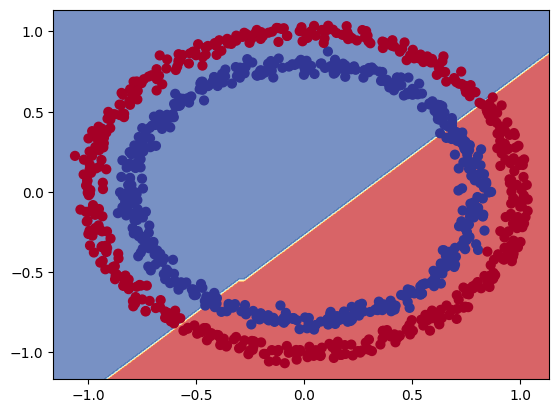

In [17]:
# Check out the predictions our model is making
plot_decision_boundary(model_3, X, y)

Looks like our model is trying to draw a straight line through the data.

What's wrong with doing this?

The main issue is our data isn't separable by a straight line.

In a regression problem, our model might work. Let's try it.

In [18]:
# Set random seed
tf.random.set_seed(42)

# Create some regression data
X_regression = np.arange(0, 1000, 5)
y_regression = np.arange(100, 1100, 5)

# Split it into training and test sets
X_reg_train = X_regression[:150]
X_reg_test = X_regression[150:]
y_reg_train = y_regression[:150]
y_reg_test = y_regression[150:]

# Fit our model to the data
# Note: Before TensorFlow 2.7.0, this line would work
# model_3.fit(X_reg_train, y_reg_train, epochs=100)

# After TensorFlow 2.7.0, see here for more: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/278
model_3.fit(tf.expand_dims(X_reg_train, axis=-1),
            y_reg_train,
            epochs=100)

Epoch 1/100


ValueError: ignored

In [19]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 100)               300       
                                                                 
 dense_4 (Dense)             (None, 10)                1010      
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1321 (5.16 KB)
Trainable params: 1321 (5.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Oh wait... we compiled our model for a binary classification problem.

No trouble, we can recreate it for a regression problem.

In [20]:
# Setup random seed
tf.random.set_seed(42)

# Recreate the model
model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(100),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(1)
])

# Change the loss and metrics of our compiled model
model_3.compile(loss=tf.keras.losses.mae,   # change the loss function to be regression-specific
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae'])            # change the metric to be regression-specific

# Fit the recompiled model
model_3.fit(tf.expand_dims(X_reg_train, axis=-1),
            y_reg_train,
            epochs=100)

Epoch 1/100
5/5 [==============================] - 1s 4ms/step - loss: 393.2901 - mae: 393.2901
Epoch 2/100
5/5 [==============================] - 0s 3ms/step - loss: 266.6307 - mae: 266.6307
Epoch 3/100
5/5 [==============================] - 0s 3ms/step - loss: 143.8059 - mae: 143.8059
Epoch 4/100
5/5 [==============================] - 0s 3ms/step - loss: 50.0209 - mae: 50.0209
Epoch 5/100
5/5 [==============================] - 0s 3ms/step - loss: 84.5663 - mae: 84.5663
Epoch 6/100
5/5 [==============================] - 0s 4ms/step - loss: 77.4882 - mae: 77.4882
Epoch 7/100
5/5 [==============================] - 0s 4ms/step - loss: 45.4943 - mae: 45.4943
Epoch 8/100
5/5 [==============================] - 0s 3ms/step - loss: 54.5033 - mae: 54.5033
Epoch 9/100
5/5 [==============================] - 0s 4ms/step - loss: 44.1687 - mae: 44.1687
Epoch 10/100
5/5 [==============================] - 0s 4ms/step - loss: 46.5619 - mae: 46.5619
Epoch 11/100
5/5 [==============================] - 0

Okay, it seems like our model is learning something (the `mae` value trends down with each epoch), let's plot its predictions.

2/2 [==============================] - 0s 11ms/step


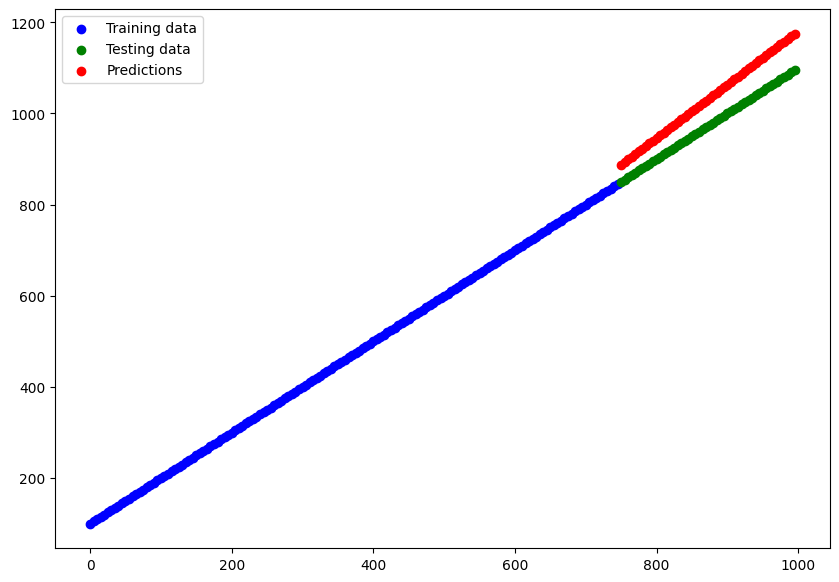

In [21]:
# Make predictions with our trained model
y_reg_preds = model_3.predict(X_reg_test)

# Plot the model's predictions against our regression data
plt.figure(figsize=(10, 7))
plt.scatter(X_reg_train, y_reg_train, c='b', label='Training data')
plt.scatter(X_reg_test, y_reg_test, c='g', label='Testing data')
plt.scatter(X_reg_test, y_reg_preds.squeeze(), c='r', label='Predictions')
plt.legend();

Okay, the predictions aren't perfect (if the predictions were perfect, the red would line up with the green), but they look better than complete guessing.

So this means our model must be learning something...

There must be something we're missing out on for our classification problem.

## The missing piece: Non-linearity

Okay, so we saw our neural network can model straight lines (with the ability a little bit better than guessing).

What about non-straight (non-linear) lines?

If we're going to model our classification data (the red and blue circles), we're going to need some non-linear lines.

> 🔨 Practice: Before we get to the next steps, I'd encourage you to play around with the [TensorFlow Playground](https://playground.tensorflow.org/#activation=linear&batchSize=1&dataset=circle&regDataset=reg-plane&learningRate=0.01&regularizationRate=0&noise=0&networkShape=1&seed=0.09561&showTestData=false&discretize=false&percTrainData=70&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularizationRate_hide=true&discretize_hide=true&regularization_hide=true&dataset_hide=true&noise_hide=true&batchSize_hide=true) (check out what the data has in common with our own classification data) for 10-minutes. In particular, the tab that says "activation". Once you're done, come back.

Did you try out the activation options? If so, what did you find?

If you didn't, don't worry, let's see it in code.

We're going to replicate the neural network you can see at this link: [TensorFlow Playground](https://playground.tensorflow.org/#activation=linear&batchSize=1&dataset=circle&regDataset=reg-plane&learningRate=0.01&regularizationRate=0&noise=0&networkShape=1&seed=0.09561&showTestData=false&discretize=false&percTrainData=70&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularizationRate_hide=true&discretize_hide=true&regularization_hide=true&dataset_hide=true&noise_hide=true&batchSize_hide=true).

![image1](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-tensorflow-playground-simple-net-linear-activation.png)
*The neural network we're going to recreate with TensorFlow code. See it live at [TensorFlow Playground](https://playground.tensorflow.org/#activation=linear&batchSize=1&dataset=circle&regDataset=reg-plane&learningRate=0.01&regularizationRate=0&noise=0&networkShape=1&seed=0.09561&showTestData=false&discretize=false&percTrainData=70&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularizationRate_hide=true&discretize_hide=true&regularization_hide=true&dataset_hide=true&noise_hide=true&batchSize_hide=true).*

The main change we'll add to models we've built before is the use of the `activation` keyword.

In [22]:
# Set the random seed
tf.random.set_seed(42)

# Create the model
model_4 = tf.keras.Sequential([
  tf.keras.layers.Dense(1, activation=tf.keras.activations.linear), # 1 hidden layer with linear activation
  tf.keras.layers.Dense(1)                                          # output layer
])

# Compile the model
model_4.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # note: "lr" used to be what was used, now "learning_rate" is favored
                metrics=["accuracy"])

# Fit the model
history = model_4.fit(X, y, epochs=100)

Epoch 1/100
32/32 [==============================] - 2s 4ms/step - loss: 6.6965 - accuracy: 0.4870
Epoch 2/100
32/32 [==============================] - 0s 4ms/step - loss: 6.6698 - accuracy: 0.4870
Epoch 3/100
32/32 [==============================] - 0s 4ms/step - loss: 6.6625 - accuracy: 0.4870
Epoch 4/100
32/32 [==============================] - 0s 2ms/step - loss: 6.6551 - accuracy: 0.4860
Epoch 5/100
32/32 [==============================] - 0s 2ms/step - loss: 6.6550 - accuracy: 0.4870
Epoch 6/100
32/32 [==============================] - 0s 2ms/step - loss: 6.6517 - accuracy: 0.4870
Epoch 7/100
32/32 [==============================] - 0s 2ms/step - loss: 6.6512 - accuracy: 0.4870
Epoch 8/100
32/32 [==============================] - 0s 2ms/step - loss: 6.6507 - accuracy: 0.4870
Epoch 9/100
32/32 [==============================] - 0s 2ms/step - loss: 6.6503 - accuracy: 0.4870
Epoch 10/100
32/32 [==============================] - 0s 2ms/step - loss: 6.6497 - accuracy: 0.4870
Epoch 11/

Okay, our model performs a little worse than guessing.

Let's remind ourselves what our data looks like.

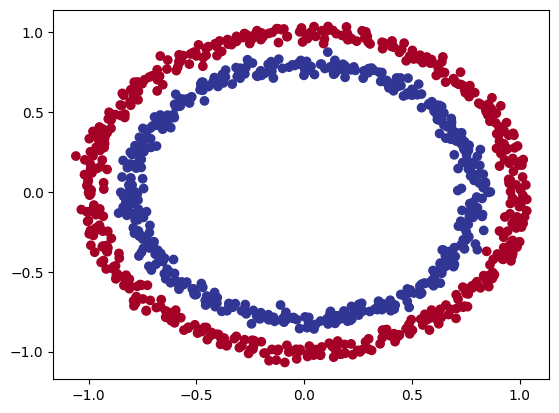

In [23]:
# Check out our data
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

And let's see how our model is making predictions on it.

313/313 [==============================] - 1s 3ms/step
doing binary classifcation...


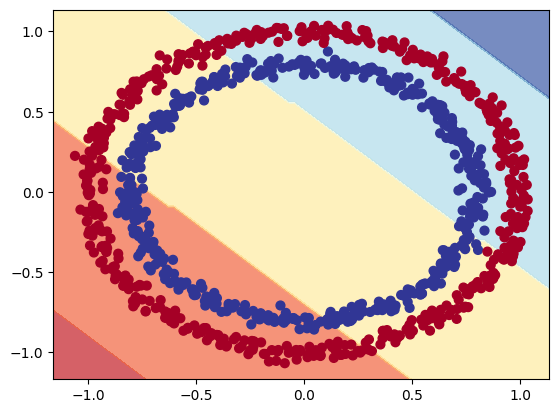

In [24]:
# Check the deicison boundary (blue is blue class, yellow is the crossover, red is red class)
plot_decision_boundary(model_4, X, y)

Well, it looks like we're getting a straight (linear) line prediction again.

But our data is non-linear (not a straight line)...

What we're going to have to do is add some non-linearity to our model.

To do so, we'll use the `activation` parameter in one of our layers.

In [25]:
# Set random seed
tf.random.set_seed(42)

# Create a model with a non-linear activation
model_5 = tf.keras.Sequential([
  tf.keras.layers.Dense(1, activation=tf.keras.activations.relu),   # can also do activation='relu'
  tf.keras.layers.Dense(1)                                          # output layer
])

# Compile the model
model_5.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history = model_5.fit(X, y, epochs=100)

Epoch 1/100
32/32 [==============================] - 1s 3ms/step - loss: 4.1938 - accuracy: 0.4890
Epoch 2/100
32/32 [==============================] - 0s 2ms/step - loss: 3.8757 - accuracy: 0.4900
Epoch 3/100
32/32 [==============================] - 0s 2ms/step - loss: 3.8010 - accuracy: 0.4890
Epoch 4/100
32/32 [==============================] - 0s 2ms/step - loss: 3.7501 - accuracy: 0.4910
Epoch 5/100
32/32 [==============================] - 0s 2ms/step - loss: 3.7100 - accuracy: 0.4900
Epoch 6/100
32/32 [==============================] - 0s 2ms/step - loss: 3.6774 - accuracy: 0.4900
Epoch 7/100
32/32 [==============================] - 0s 2ms/step - loss: 3.6500 - accuracy: 0.4900
Epoch 8/100
32/32 [==============================] - 0s 2ms/step - loss: 3.6272 - accuracy: 0.4900
Epoch 9/100
32/32 [==============================] - 0s 2ms/step - loss: 3.6066 - accuracy: 0.4900
Epoch 10/100
32/32 [==============================] - 0s 2ms/step - loss: 3.5885 - accuracy: 0.4900
Epoch 11/

Hmm... still not learning...

What we if increased the number of neurons and layers?

Say, 2 hidden layers, with [ReLU](https://www.tensorflow.org/api_docs/python/tf/keras/activations/relu), pronounced "rel-u", (short for [rectified linear unit](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/)), activation on the first one, and 4 neurons each?

To see this network in action, check out the [TensorFlow Playground demo](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.001&regularizationRate=0&noise=0&networkShape=4,4&seed=0.93799&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularization_hide=true&regularizationRate_hide=true&batchSize_hide=true&dataset_hide=true).

![image2](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-tensorflow-playground-two-layer-net-relu-activation.png)
*The neural network we're going to recreate with TensorFlow code. See it live at [TensorFlow Playground](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.001&regularizationRate=0&noise=0&networkShape=4,4&seed=0.93799&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularization_hide=true&regularizationRate_hide=true&batchSize_hide=true&dataset_hide=true).*

Let's try.

Note: in the course, Daniel used `lr` instead of `learning_rate`. But for the update, we had changed to `learning_rate` instead of `lr`.

In [26]:
# Set random seed
tf.random.set_seed(42)

# Create a model
model_6 = tf.keras.Sequential([
  tf.keras.layers.Dense(4, activation=tf.keras.activations.relu), # hidden layer 1, 4 neurons, ReLU activation
  tf.keras.layers.Dense(4, activation=tf.keras.activations.relu), # hidden layer 2, 4 neurons, ReLU activation
  tf.keras.layers.Dense(1) # ouput layer
])

# Compile the model
model_6.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # Adam's default learning rate is 0.001
                metrics=['accuracy'])

# Fit the model
history = model_6.fit(X, y, epochs=100)

Epoch 1/100
32/32 [==============================] - 1s 3ms/step - loss: 1.2415 - accuracy: 0.4740
Epoch 2/100
32/32 [==============================] - 0s 3ms/step - loss: 0.9321 - accuracy: 0.4740
Epoch 3/100
32/32 [==============================] - 0s 3ms/step - loss: 0.8570 - accuracy: 0.4740
Epoch 4/100
32/32 [==============================] - 0s 2ms/step - loss: 0.8145 - accuracy: 0.4730
Epoch 5/100
32/32 [==============================] - 0s 2ms/step - loss: 0.7848 - accuracy: 0.4730
Epoch 6/100
32/32 [==============================] - 0s 2ms/step - loss: 0.7646 - accuracy: 0.4720
Epoch 7/100
32/32 [==============================] - 0s 3ms/step - loss: 0.7495 - accuracy: 0.4520
Epoch 8/100
32/32 [==============================] - 0s 2ms/step - loss: 0.7402 - accuracy: 0.4130
Epoch 9/100
32/32 [==============================] - 0s 3ms/step - loss: 0.7313 - accuracy: 0.3730
Epoch 10/100
32/32 [==============================] - 0s 2ms/step - loss: 0.7224 - accuracy: 0.3710
Epoch 11/

In [27]:
# Evaluate the model
model_6.evaluate(X, y)

32/32 [==============================] - 0s 4ms/step - loss: 0.4040 - accuracy: 0.8430


[0.40397170186042786, 0.8429999947547913]

Now we're hitting 80%~ accuracy.

How do the predictions look?

313/313 [==============================] - 1s 2ms/step
doing binary classifcation...


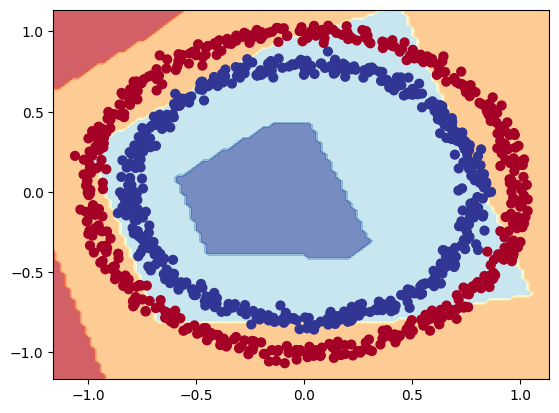

In [28]:
# Check out the predictions using 2 hidden layers
plot_decision_boundary(model_6, X, y)

What gives?

It seems like our model is the same as the one in the [TensorFlow Playground](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,4&seed=0.93799&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularization_hide=true&regularizationRate_hide=true&batchSize_hide=true) but model isn't drawing as good as the model in the playground...

Ideally, the yellow lines go on the inside of the red circle and the blue circle.

Okay, okay, let's model this circle once and for all.

One more model (I promise... actually, I'm going to have to break that promise... we'll be building plenty more models).

This time we'll change the activation function on our output layer too. Remember the architecture of a classification model? For binary classification, the output layer activation is usually the [Sigmoid activation function](https://www.tensorflow.org/api_docs/python/tf/math/sigmoid).

In [29]:
# Set random seed
tf.random.set_seed(42)

# Create a model
model_7 = tf.keras.Sequential([
  tf.keras.layers.Dense(4, activation=tf.keras.activations.relu), # hidden layer 1, ReLU activation
  tf.keras.layers.Dense(4, activation=tf.keras.activations.relu), # hidden layer 2, ReLU activation
  tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid) # ouput layer, sigmoid activation
])

# Compile the model
model_7.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit the model
history = model_7.fit(X, y, epochs=100, verbose=0)

In [30]:
# Evaluate our model
model_7.evaluate(X, y)

32/32 [==============================] - 0s 2ms/step - loss: 0.2525 - accuracy: 0.9820


[0.2525154948234558, 0.9819999933242798]

Woah! It looks like our model is getting some incredible results, let's check them out.

313/313 [==============================] - 1s 3ms/step
doing binary classifcation...


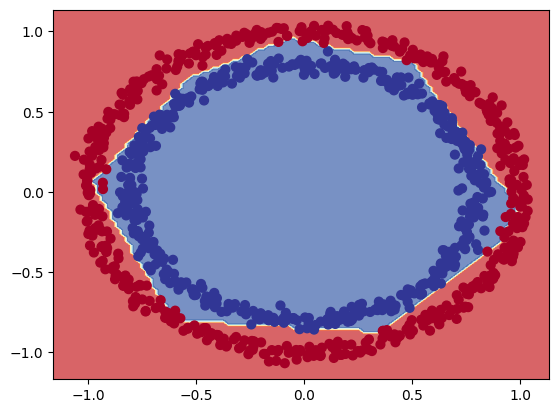

In [31]:
# View the predictions of the model with relu and sigmoid activations
plot_decision_boundary(model_7, X, y)

Nice! It looks like our model is almost perfectly (apart from a few examples) separating the two circles.

> 🤔 Question: What's wrong with the predictions we've made? Are we really evaluating our model correctly here? Hint: what data did the model learn on and what did we predict on?

Before we answer that, it's important to recognize what we've just covered.

> 🔑 Note: The combination of linear (straight lines) and non-linear (non-straight lines) functions is one of the key fundamentals of neural networks.

Think of it like this:

If I gave you an unlimited amount of straight lines and non-straight lines, what kind of patterns could you draw?

That's essentially what neural networks do to find patterns in data.

Now you might be thinking, "But I haven't seen a linear function or a non-linear function before..."

Oh, but you have.

We've been using them the whole time.

They're what power the layers in the models we just built.

To get some intuition about the activation functions we've just used, let's create them and then try them on some toy data.

In [32]:
# Create a toy tensor (similar to the data we pass into our model)
A = tf.cast(tf.range(-10, 10), tf.float32)
A

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
         1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.],
      dtype=float32)>

How does this look?

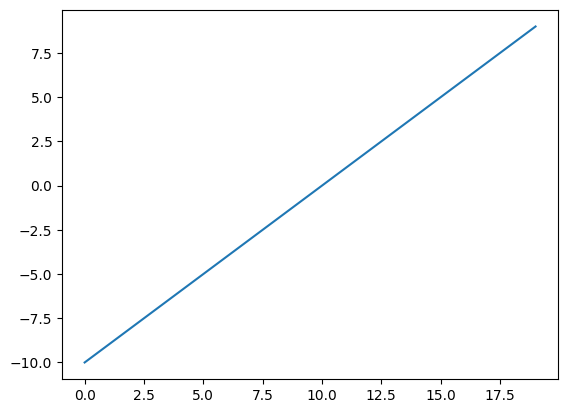

In [33]:
# Visualize our toy tensor
plt.plot(A);

A straight (linear) line!

Nice, now let's recreate the [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function) and see what it does to our data. You can also find a pre-built sigmoid function at [`tf.keras.activations.sigmoid`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/sigmoid).

In [34]:
# Sigmoid - https://www.tensorflow.org/api_docs/python/tf/keras/activations/sigmoid
def sigmoid(x):
    return 1 / (1 + tf.exp(-x))

# Use the sigmoid function on our tensor
sigmoid(A)

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([4.5397872e-05, 1.2339458e-04, 3.3535014e-04, 9.1105117e-04,
       2.4726233e-03, 6.6928510e-03, 1.7986210e-02, 4.7425874e-02,
       1.1920292e-01, 2.6894143e-01, 5.0000000e-01, 7.3105860e-01,
       8.8079703e-01, 9.5257413e-01, 9.8201376e-01, 9.9330717e-01,
       9.9752742e-01, 9.9908900e-01, 9.9966466e-01, 9.9987662e-01],
      dtype=float32)>

And how does it look?

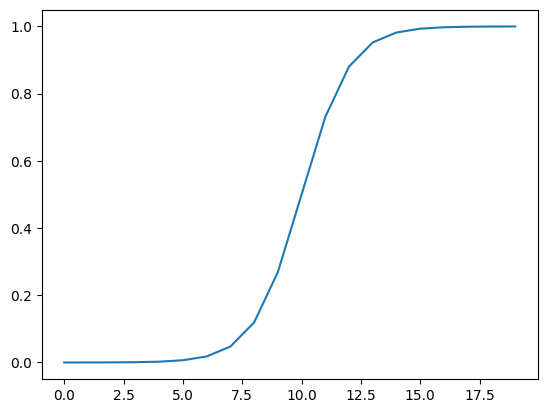

In [35]:
# Plot sigmoid modified tensor
plt.plot(sigmoid(A));

A non-straight (non-linear) line!

Okay, how about the [ReLU function](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/#:~:text=The%20rectified%20linear%20activation%20function,otherwise%2C%20it%20will%20output%20zero.) (ReLU turns all negatives to 0 and positive numbers stay the same)?

In [36]:
# ReLU - https://www.tensorflow.org/api_docs/python/tf/keras/activations/relu
def relu(x):
    return tf.maximum(0, x)

# Pass toy tensor through ReLU function
relu(A)

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6.,
       7., 8., 9.], dtype=float32)>

How does the ReLU-modified tensor look?

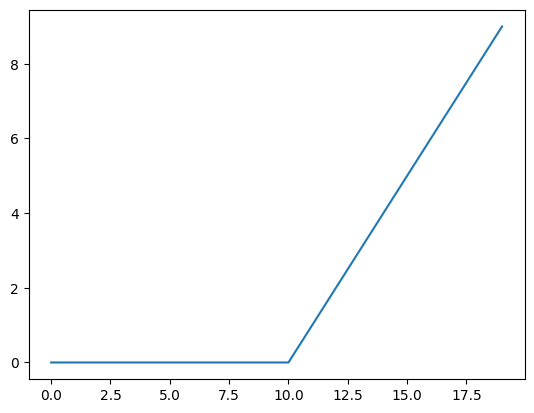

In [37]:
# Plot ReLU-modified tensor
plt.plot(relu(A));

Another non-straight line!

Well, how about TensorFlow's [linear activation function](https://www.tensorflow.org/api_docs/python/tf/keras/activations/linear)?

In [38]:
# Linear - https://www.tensorflow.org/api_docs/python/tf/keras/activations/linear (returns input non-modified...)
tf.keras.activations.linear(A)

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
         1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.],
      dtype=float32)>

Hmm, it looks like our inputs are unmodified...

In [39]:
# Does the linear activation change anything?
A == tf.keras.activations.linear(A)

<tf.Tensor: shape=(20,), dtype=bool, numpy=
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])>

Okay, so it makes sense now the model doesn't learn anything when using only linear activation functions, because the linear activation function doesn't change our input data in any way.

Whereas, with our non-linear functions, our data gets manipulated. A neural network uses these kinds of transformations at a large scale to draw patterns between its inputs and outputs.

Now rather than dive into the guts of neural networks, we're going to keep coding applying what we've learned to different problems but if you want a more in-depth look at what's going on behind the scenes, check out the Extra Curriculum section below.

> 📖 Resource: For more on activation functions, check out the [machine learning cheatsheet page](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#) on them.

## Evaluating and improving our classification model

If you answered the question above, you might've picked up what we've been doing wrong.

We've been evaluating our model on the same data it was trained on.

A better approach would be to split our data into training, validation (optional), and test sets.

Once we've done that, we'll train our model on the training set (let it find patterns in the data) and then see how well it learned the patterns by using it to predict values on the test set.

Let's do it.

In [40]:
# How many examples are in the whole dataset?
len(X)

1000

In [41]:
# Split data into train and test sets
X_train, y_train = X[:800], y[:800] # 80% of the data for the training set
X_test, y_test = X[800:], y[800:] # 20% of the data for the test set

# Check the shapes of the data
X_train.shape, X_test.shape # 800 examples in the training set, 200 examples in the test set

((800, 2), (200, 2))

Great, now we've got training and test sets, let's model the training data and evaluate what our model has learned on the test set.

In [42]:
# Set random seed
tf.random.set_seed(42)

# Create the model (same as model_7)
model_8 = tf.keras.Sequential([
  tf.keras.layers.Dense(4, activation="relu"), # hidden layer 1, using "relu" for activation (same as tf.keras.activations.relu)
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(1, activation="sigmoid") # output layer, using 'sigmoid' for the output
])

# Compile the model
model_8.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), # increase learning rate from 0.001 to 0.01 for faster learning
                metrics=['accuracy'])

# Fit the model
history = model_8.fit(X_train, y_train, epochs=25)

Epoch 1/25
25/25 [==============================] - 1s 5ms/step - loss: 0.6883 - accuracy: 0.5175
Epoch 2/25
25/25 [==============================] - 0s 5ms/step - loss: 0.6816 - accuracy: 0.5475
Epoch 3/25
25/25 [==============================] - 0s 4ms/step - loss: 0.6745 - accuracy: 0.5487
Epoch 4/25
25/25 [==============================] - 0s 4ms/step - loss: 0.6644 - accuracy: 0.6037
Epoch 5/25
25/25 [==============================] - 0s 5ms/step - loss: 0.6480 - accuracy: 0.6425
Epoch 6/25
25/25 [==============================] - 0s 5ms/step - loss: 0.6158 - accuracy: 0.7188
Epoch 7/25
25/25 [==============================] - 0s 4ms/step - loss: 0.5755 - accuracy: 0.8612
Epoch 8/25
25/25 [==============================] - 0s 4ms/step - loss: 0.5315 - accuracy: 0.8737
Epoch 9/25
25/25 [==============================] - 0s 4ms/step - loss: 0.4698 - accuracy: 0.9250
Epoch 10/25
25/25 [==============================] - 0s 4ms/step - loss: 0.4090 - accuracy: 0.9388
Epoch 11/25
25/25 [

In [43]:
# Evaluate our model on the test set
loss, accuracy = model_8.evaluate(X_test, y_test)
print(f"Model loss on the test set: {loss}")
print(f"Model accuracy on the test set: {100*accuracy:.2f}%")

7/7 [==============================] - 0s 3ms/step - loss: 0.0488 - accuracy: 0.9900
Model loss on the test set: 0.04883350431919098
Model accuracy on the test set: 99.00%


Near 100% accuracy? Nice!

Now, when we started to create `model_8` we said it was going to be the same as `model_7` but you might've found that to be a little lie.

That's because we changed a few things:

- The activation parameter - We used strings (`"relu"` & `"sigmoid"`) instead of using library paths (`tf.keras.activations.relu`), in TensorFlow, they both offer the same functionality.
- The `learning_rate` (also `lr`) parameter - We increased the learning rate parameter in the [Adam optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) to `0.01` instead of `0.001` (an increase of 10x).
    - You can think of the learning rate as how quickly a model learns. The higher the learning rate, the faster the model's capacity to learn, however, there's such a thing as a *too-high* learning rate, where a model tries to learn too fast and doesn't learn anything. We'll see a trick to find the ideal learning rate soon.
- The number of epochs - We lowered the number of epochs (using the `epochs` parameter) from 100 to 25 but our model still got an incredible result on both the training and test sets.
    - One of the reasons our model performed well in even fewer epochs (remember a single epoch is a model trying to learn patterns in the data by looking at it once, so 25 epochs means the model gets 25 chances) than before is because we increased the learning rate.
    
We know our model is performing well based on the evaluation metrics but let's see how it performs visually.

313/313 [==============================] - 1s 3ms/step
doing binary classifcation...
313/313 [==============================] - 2s 5ms/step
doing binary classifcation...


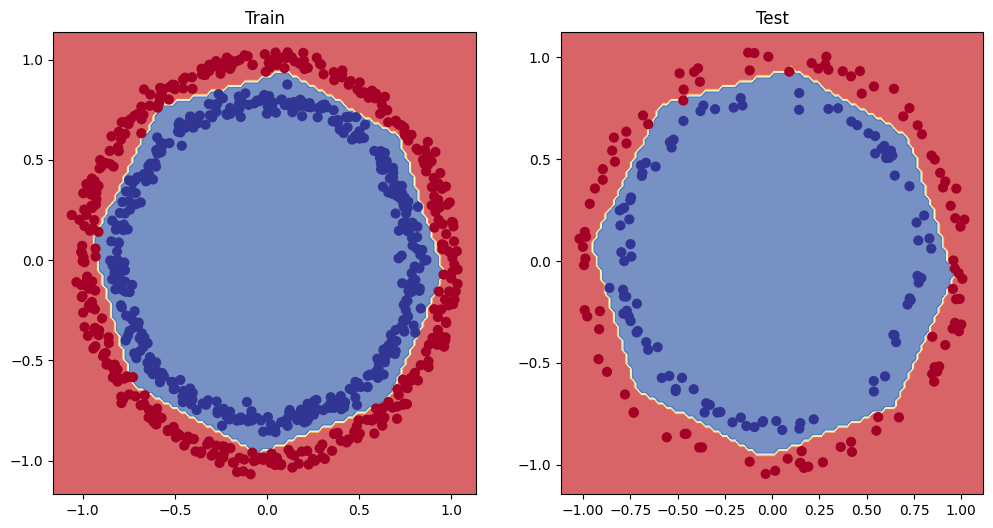

In [44]:
# Plot the decision boundaries for the training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_8, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_8, X=X_test, y=y_test)
plt.show()

Check that out! How cool. With a few tweaks, our model is now predicting the blue and red circles almost perfectly.

### Plot the loss curves

Looking at the plots above, we can see the outputs of our model are very good.

But how did our model go whilst it was learning?

As in, how did the performance change everytime the model had a chance to look at the data (once every epoch)?

To figure this out, we can check the loss curves (also referred to as the learning curves).

You might've seen we've been using the variable `history` when calling the `fit()` function on a model ([`fit()` returns a `History` object](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit)).

This is where we'll get the information for how our model is performing as it learns.

Let's see how we might use it.

In [45]:
# You can access the information in the history variable using the .history attribute
pd.DataFrame(history.history)

,loss,accuracy
0,0.688300,0.51750
1,0.681555,0.54750
2,0.674542,0.54875
3,0.664450,0.60375
4,0.647967,0.64250
5,0.615843,0.71875
6,0.575523,0.86125
7,0.531479,0.87375
8,0.469792,0.92500
9,0.408965,0.93875


Inspecting the outputs, we can see the loss values going down and the accuracy going up.

How does it look (visualize, visualize, visualize)?

Text(0.5, 1.0, 'Model_8 training curves')

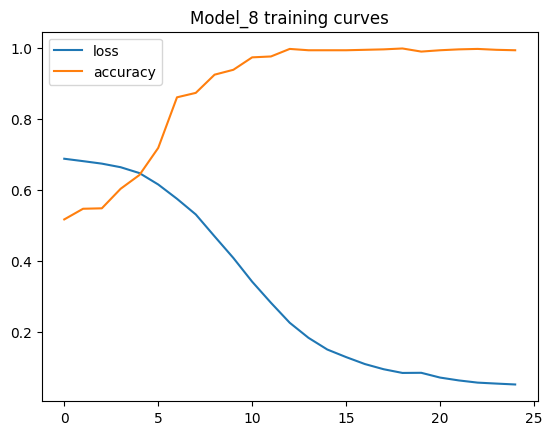

In [46]:
# Plot the loss curves
pd.DataFrame(history.history).plot()
plt.title("Model_8 training curves")

Beautiful. This is the ideal plot we'd be looking for when dealing with a classification problem, loss going down, accuracy going up.

> 🔑 Note: For many problems, the loss function going down means the model is improving (the predictions it's making are getting closer to the ground truth labels).

### Finding the best learning rate

Aside from the architecture itself (the layers, number of neurons, activations, etc), the most important hyperparameter you can tune for your neural network models is the learning rate.

In `model_8` you saw we lowered the Adam optimizer's learning rate from the default of `0.001` (default) to `0.01`.

And you might be wondering why we did this.

Put it this way, it was a lucky guess.

I just decided to try a lower learning rate and see how the model went.

Now you might be thinking, "Seriously? You can do that?"

And the answer is yes. You can change any of the hyperparamaters of your neural networks.

With practice, you'll start to see what kind of hyperparameters work and what don't.

That's an important thing to understand about machine learning and deep learning in general. It's very experimental. You build a model and evaluate it, build a model and evaluate it.

That being said, I want to introduce you to a trick that will help you find the optimal learning rate (at least to begin training with) for your models going forward.

To do so, we're going to use the following:

- A [learning rate callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler).
    - You can think of a callback as an extra piece of functionality you can add to your model while it's training.
- Another model (we could use the same ones as above, we were practicing building models here).
- A modified loss curves plot.

We'll go through each with code, then explain what's going on.

> 🔑 Note: The default hyperparameters of many neural network building blocks in TensorFlow are set up in a way that usually works right out of the box (e.g. the [Adam optimizer's](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) default settings can usually get good results on many datasets). So it's a good idea to try the defaults first, then adjust as needed.

In [47]:
# Set random seed
tf.random.set_seed(42)

# Create a model (same as model_8)
model_9 = tf.keras.Sequential([
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model
model_9.compile(loss="binary_crossentropy", # we can use strings here too
                optimizer="Adam",           # same as tf.keras.optimizers.Adam() with default settings
                metrics=["accuracy"])

# Create a learning rate scheduler callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10 ** (epoch / 20)) # traverse a set of learning rate values starting from 1e-4, increasing by 10**(epoch/20) every epoch

# Fit the model (passing the lr_scheduler callback)
history = model_9.fit(X_train,
                      y_train,
                      epochs=100,
                      callbacks=[lr_scheduler])

Epoch 1/100
25/25 [==============================] - 2s 4ms/step - loss: 0.6894 - accuracy: 0.5113 - lr: 1.0000e-04
Epoch 2/100
25/25 [==============================] - 0s 4ms/step - loss: 0.6893 - accuracy: 0.5100 - lr: 1.1220e-04
Epoch 3/100
25/25 [==============================] - 0s 6ms/step - loss: 0.6892 - accuracy: 0.5150 - lr: 1.2589e-04
Epoch 4/100
25/25 [==============================] - 0s 4ms/step - loss: 0.6892 - accuracy: 0.5163 - lr: 1.4125e-04
Epoch 5/100
25/25 [==============================] - 0s 6ms/step - loss: 0.6891 - accuracy: 0.5150 - lr: 1.5849e-04
Epoch 6/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6890 - accuracy: 0.5163 - lr: 1.7783e-04
Epoch 7/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6889 - accuracy: 0.5213 - lr: 1.9953e-04
Epoch 8/100
25/25 [==============================] - 0s 4ms/step - loss: 0.6888 - accuracy: 0.5225 - lr: 2.2387e-04
Epoch 9/100
25/25 [==============================] - 0s 3ms/step - loss:

Now our model has finished training, let's have a look at the training history.

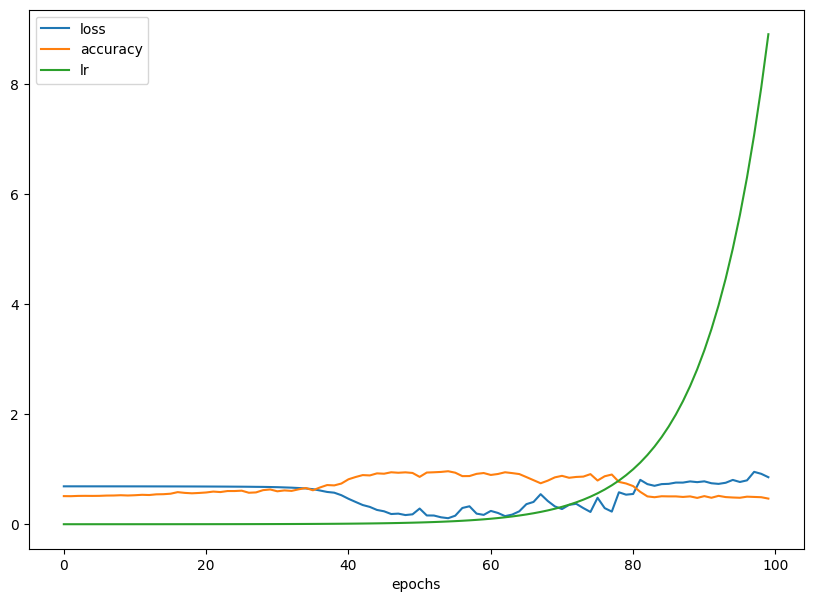

In [48]:
# Checkout the history
pd.DataFrame(history.history).plot(figsize=(10, 7), xlabel='epochs');

The learning rate exponentially increases as the number of epochs increases.

And you can see the model's accuracy goes up (and loss goes down) at a specific point when the learning rate slowly increases.

To figure out where this infliction point is, we can plot the loss versus the log-scale learning rate.

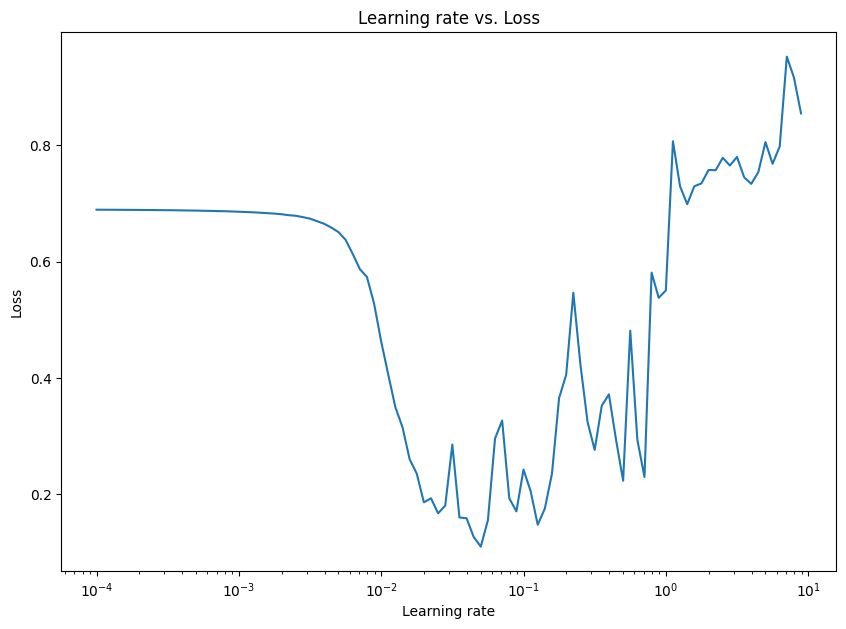

In [50]:
# Plot the learning rate versus the loss
lrs = 1e-4 * (10 ** (np.arange(100) / 20))
plt.figure(figsize=(10, 7))
plt.semilogx(lrs, history.history["loss"]) # we want the x-axis to be log scaled
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.title("Learning rate vs. Loss");

To figure out the ideal value of the learning rate (at least the ideal value to *begin* training our model), the rule of thumb is to take the learning rate value where the loss is still decreasing but not quite flattened out (usually about 10x smaller than the bottom of the curve).

In this case, our ideal learning rate ends up between `0.01` ($10^{-2}$) and `0.02`.

![image3](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-learning-rate-vs-loss.png)

*The ideal learning rate at the start of model training is somewhere just before the loss curve bottoms out (a value where the loss is still decreasing).*

In [51]:
# Example of other typical learning rate values
10**0, 10**-1, 10**-2, 10**-3, 1e-4

(1, 0.1, 0.01, 0.001, 0.0001)

Now we've estimated the ideal learning rate (we'll use `0.02`) for our model, let's refit it.

In [53]:
# Set the random seed
tf.random.set_seed(42)

# Create the model
model_10 = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model with the ideal learning rate
model_10.compile(loss='binary_crossentropy',
                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.02), # to adjust the learning rate, you need to use tf.keras.optimizers.Adam (not 'Adam')
                 metrics=['accuracy'])

# Fit the model for 20 epochs (5 less than before)
history = model_10.fit(X_train, y_train, epochs = 20)

Epoch 1/20
25/25 [==============================] - 1s 3ms/step - loss: 0.7019 - accuracy: 0.4375
Epoch 2/20
25/25 [==============================] - 0s 2ms/step - loss: 0.6898 - accuracy: 0.4888
Epoch 3/20
25/25 [==============================] - 0s 3ms/step - loss: 0.6832 - accuracy: 0.5375
Epoch 4/20
25/25 [==============================] - 0s 2ms/step - loss: 0.6773 - accuracy: 0.5612
Epoch 5/20
25/25 [==============================] - 0s 3ms/step - loss: 0.6678 - accuracy: 0.5638
Epoch 6/20
25/25 [==============================] - 0s 3ms/step - loss: 0.6483 - accuracy: 0.5962
Epoch 7/20
25/25 [==============================] - 0s 3ms/step - loss: 0.6273 - accuracy: 0.6488
Epoch 8/20
25/25 [==============================] - 0s 2ms/step - loss: 0.6133 - accuracy: 0.6762
Epoch 9/20
25/25 [==============================] - 0s 2ms/step - loss: 0.5805 - accuracy: 0.6925
Epoch 10/20
25/25 [==============================] - 0s 3ms/step - loss: 0.4928 - accuracy: 0.8213
Epoch 11/20
25/25 [

Nice! With a little higher learning rate (`0.02` instead of `0.01`) we reach a higher accuracy than `model_8` in less epochs (`20` instead of `25`).

> 🛠 Practice: Now you've seen an example of what can happen when you change the learning rate, try changing the learning rate value in the [TensorFlow Playground](https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.03154&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularization_hide=true&regularizationRate_hide=true&problem_hide=true) and see what happens. What happens if you increase it? What happens if you decrease it?

In [54]:
# Evaluate model on the test dataset
model_10.evaluate(X_test, y_test)

7/7 [==============================] - 0s 3ms/step - loss: 0.0786 - accuracy: 0.9900


[0.07859303802251816, 0.9900000095367432]

Let's see how the predictions look.

313/313 [==============================] - 1s 2ms/step
doing binary classifcation...
313/313 [==============================] - 1s 2ms/step
doing binary classifcation...


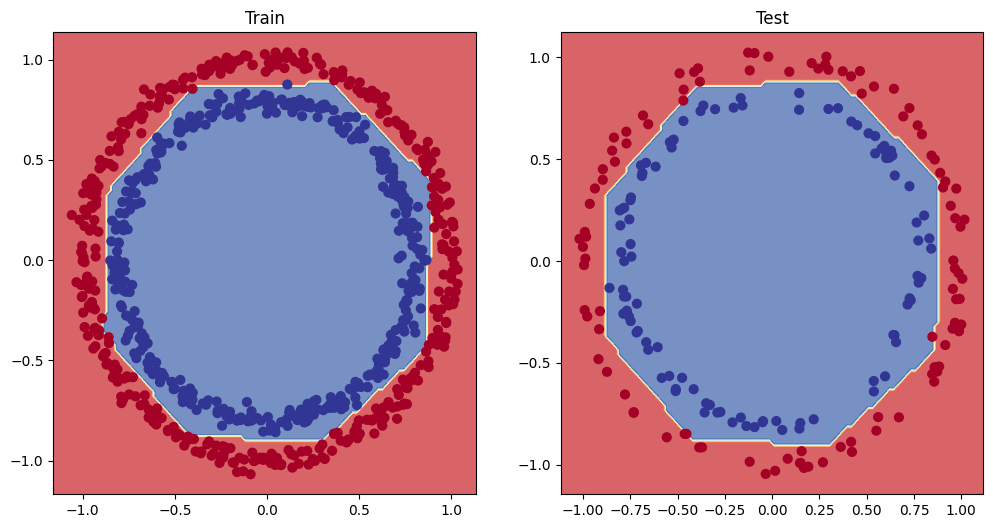

In [55]:
# Plot the decision boundaries for the training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_10, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_10, X=X_test, y=y_test)
plt.show()

And as we can see, almost perfect again.

These are the kinds of experiments you'll be running often when building your models.

Start with default settings and see how they perform on your data.

And if they don't perform as well as you'd like, improve them.

Let's look at a few more ways to evaluate our classification models.

### More classification evaluation methods

Alongside the visualizations we've been making, there are several different evaluation metrics we can use to evaluate our classification models.

